<a target="_blank" href="https://colab.research.google.com/github/rapidsai-community/showcase/blob/main/getting_started_tutorials/rapids-pip-colab-template.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Install RAPIDS into Colab"/>
</a>

# RAPIDS cuDF is now already on your Colab instance!
RAPIDS cuDF is preinstalled on Google Colab and instantly accelerates Pandas with zero code changes. [You can quickly get started with our tutorial notebook](https://nvda.ws/rapids-cudf). This notebook template is for users who want to utilize the full suite of the RAPIDS libraries for their workflows on Colab.  

# Environment Sanity Check #

Click the _Runtime_ dropdown at the top of the page, then _Change Runtime Type_ and confirm the instance type is _GPU_.

You can check the output of `!nvidia-smi` to check which GPU you have.  Please uncomment the cell below if you'd like to do that.  Currently, RAPIDS runs on all available Colab GPU instances.

In [18]:
# !nvidia-smi

#Setup:
This set up script:

1. Checks to make sure that the GPU is RAPIDS compatible
1. Pip Installs the RAPIDS' libraries, which are:
  1. cuDF
  1. cuML
  1. cuGraph
  1. cuSpatial
  1. cuxFilter
  1. cuCIM
  1. xgboost

# Controlling Which RAPIDS Version is Installed
This line in the cell below, `!python rapidsai-csp-utils/colab/pip-install.py`, kicks off the RAPIDS installation script.  You can control the RAPIDS version installed by adding either `latest`, `nightlies` or the default/blank option.  Example:

`!python rapidsai-csp-utils/colab/pip-install.py <option>`

You can now tell the script to install:
1. **RAPIDS + Colab Default Version**, by leaving the install script option blank (or giving an invalid option), adds the rest of the RAPIDS libraries to the RAPIDS cuDF library preinstalled on Colab.  **This is the default and recommended version.**  Example: `!python rapidsai-csp-utils/colab/pip-install.py`
1. **Latest known working RAPIDS stable version**, by using the option `latest` upgrades all RAPIDS labraries to the latest working RAPIDS stable version.  Usually early access for future RAPIDS+Colab functionality - some functionality may not work, but can be same as the default version. Example: `!python rapidsai-csp-utils/colab/pip-install.py latest`
1. **the current nightlies version**, by using the option, `nightlies`, installs current RAPIDS nightlies version.  For RAPIDS Developer use - **not recommended/untested**.  Example: `!python rapidsai-csp-utils/colab/pip-install.py nightlies`


**This will complete in about 5-6 minutes**

In [19]:
# This get the RAPIDS-Colab install files and test check your GPU.  Run this and the next cell only.
# Please read the output of this cell.  If your Colab Instance is not RAPIDS compatible, it will warn you and give you remediation steps.
!git clone https://github.com/rapidsai/rapidsai-csp-utils.git
!python rapidsai-csp-utils/colab/pip-install.py


fatal: destination path 'rapidsai-csp-utils' already exists and is not an empty directory.
Installing RAPIDS remaining 25.04 libraries
Using Python 3.11.12 environment at: /usr
Audited 11 packages in 92ms

        ***********************************************************************
        The pip install of RAPIDS is complete.

        Please do not run any further installation from the conda based installation methods, as they may cause issues!

        Please ensure that you're pulling from the git repo to remain updated with the latest working install scripts.

        Troubleshooting:
            - If there is an installation failure, please check back on RAPIDSAI owned templates/notebooks to see how to update your personal files.
            - If an installation failure persists when using the latest script, please make an issue on https://github.com/rapidsai-community/rapidsai-csp-utils
        ***********************************************************************
        


# RAPIDS is now installed on Colab.  
You can copy your code into the cells below or use the below to validate your RAPIDS installation and version.  
# Enjoy!

In [20]:
import cudf
cudf.__version__

'25.04.00'

In [21]:
import cuml
cuml.__version__

'25.04.00'

In [22]:
import cugraph
cugraph.__version__

'25.04.01'

In [23]:
import cuspatial
cuspatial.__version__

'25.04.00'

In [24]:
import cuxfilter
cuxfilter.__version__

'25.04.00'

# Next Steps #

For an overview of how you can access and work with your own datasets in Colab, check out [this guide](https://towardsdatascience.com/3-ways-to-load-csv-files-into-colab-7c14fcbdcb92).

For more RAPIDS examples, check out our RAPIDS notebooks repos:
1. https://github.com/rapidsai/notebooks
2. https://github.com/rapidsai/notebooks-contrib

In [25]:
!pip install -q git+https://github.com/pyg-team/pytorch_geometric.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [26]:
import networkx as nx
# from neulay import NeuLay
import time
import pandas as pd
import matplotlib.pyplot as plt

In [27]:
from torch_geometric.nn.pool import radius
import torch
from torch import nn

import os
import time

V = lambda x: x.detach().cpu().numpy()
from numpy import newaxis, mean, savetxt
import networkx as nx

from scipy import spatial
from scipy.spatial import cKDTree

#GCN -----------
from torch_geometric.nn import GCNConv

#GAT ----------
from torch_geometric.nn import GATConv

#GN -----------
from torch.nn import Sequential as Seq, Linear as Lin, ReLU

class NodeModel(torch.nn.Module):
    def __init__(self, in_feat, out_feat):
        super().__init__()

        self.in_feat = in_feat
        self.out_feat = out_feat

        self.node_mlp_1 = Seq(Lin(self.in_feat, self.in_feat, bias = False), ReLU(), Lin(self.in_feat, self.in_feat, bias = False))
        self.node_mlp_2 = Seq(Lin(2*self.in_feat, self.in_feat, bias = False), ReLU(), Lin(self.in_feat, self.out_feat, bias = False))

    def forward(self, x, edge_index):
        # x: [N, F_x], where N is the number of nodes.
        # edge_index: [2, E] with max entry N - 1.
        # edge_attr: [E, F_e]
        # u: [B, F_u]
        # batch: [N] with max entry B - 1.
        row, col = edge_index
        out = x[row]
        out = self.node_mlp_1(out)
        out = scatter_mean(out, col, dim=0, dim_size=x.size(0))
        out = torch.cat([x, out], dim=1)

        return self.node_mlp_2(out)


#Loss function -----------

MIN_REPUL_DIST = 1e-3
radius = .4
magnitude = 10

def Repulsion(X):
    # assuming X: (n,d)
    dX = X[newaxis] - X[:,newaxis] # (n,n,d)
    # have to remove the diagonal (self-loops)
    # dX shouldn't be calc'd for self.
    # mask = torch.ones(len(X), len(X))- torch.eye(len(X))
    #return torch.sum(1/ (MIN_REPUL_DIST + torch.norm(dX, dim=(-1))))

    r = torch.sum( dX**2, dim = -1)
    return magnitude*torch.sum(torch.exp( -r/4/(radius**2) ))



def Elastic(X, A):
    D = torch.diag(torch.sum(A,dim = 1))
    # Laplacian
    L = D - A
    return torch.trace(X.t() @ L @ X)

def Loss(X,A,c=1):
    return Elastic(X,A) + c * Repulsion(X)


def Elastic_edgelist(X, edg):
    # if edg.shape[-1] == 2:
    return torch.sum((X[edg[:,0]]-X[edg[:,1]])**2)/2

def Loss_edgelist(X,edg,c=1):
    return Elastic_edgelist(X,edg) + c * Repulsion(X)


#Alternative GCN models -----------
class GCN(nn.Module):
    def __init__(self, in_feat, out_feat, A=None, edgelist=None, N=None):
        """A: Adjacency matrix
        if A is gven, edgelist ignored.
        If edglelist given, max index in edgelist is assumed to be number of nodes N, unless N is given.
        """
        super(GCN,self).__init__()
        if A!=None:
            self.A = torch.as_tensor(A)
        elif len(edgelist):
            raise

        self.in_feat = in_feat
        self.out_feat = out_feat
        self.W = nn.Parameter(torch.empty(in_feat, out_feat))
        nn.init.kaiming_normal_(self.W)

    def forward(self, x):
        return self.A @ x @ self.W


class GCN_Lowrank(nn.Module):
    def __init__(self, in_feat, out_feat, A=None, pc_num_frac = 0.1,
                 edgelist=None, N=None):
        """A: Adjacency matrix
        if A is gven, edgelist ignored.
        If edglelist given, max index in edgelist is assumed to be number of nodes N, unless N is given.
        """
        super(GCN_Lowrank,self).__init__()
        if A!=None:
            self.A = torch.as_tensor(A)
            self._prep_A_lowrank(A, pc_num_frac)
        elif len(edgelist):
            raise

        self.in_feat = in_feat
        self.out_feat = out_feat
        self.W = nn.Parameter(torch.empty(in_feat, out_feat))
        nn.init.kaiming_normal_(self.W)

    def _prep_A_lowrank(self, A, pc_num_frac):
        A = torch.as_tensor(A)
        A = (A+A.t())/2
        v,p = torch.linalg.eigh(A)
        k = int(pc_num_frac * len(A))
        idx = torch.argsort(v, descending=True)[:k]
        self.pval, self.pvec = v[:k], p[:,:k]
        self.pvec_tv = (self.pvec * self.pval).t()

    def agg(self,x):
        x = self.pvec_tv @ x
        return self.pvec @ x

    def forward(self, x):
        # return self.A @ x @ self.W
        return self.agg(x) @ self.W


def time_it(f):
    def dt(*args, **kw):
        t0 = time.time()
        a = f(*args, **kw)
        print('%s time: %.3g s'%(f.__name__,time.time()-t0))
        # return a
    return dt

#NeuLay model -----------

class ResGCN(nn.Module):
    def __init__(self, feat_dims = [1,1], A=None, edge_index = None, edgelist=None, normalize_A = True,
                activation = None, device = None, lr = 1e-2, GCN_class = GCN):
        super(ResGCN,self).__init__()
        if device==None:
            device = ('cuda' if torch.cuda.is_available() else 'cpu')
            print(device)
        self.device = torch.device(device)

        if edgelist!=None:
            self.edgelist = torch.tensor(edgelist, dtype = torch.long).to(self.device)
            A = torch.zeros(n,n, dtype = torch.float32).to(self.device)
            for i,j in self.edgelist:
                A[i,j] = 1
                # A[j,i] = 1
            self.Loss = lambda x: Loss_edgelist(x,self.edgelist)
            self.A = torch.as_tensor(A).to(self.device)

        elif A!=None:
            self.A = torch.as_tensor(A).to(self.device)
            self.Loss = lambda x: Loss(x, self.A)

        self.edge_index = edge_index.to(self.device)

        if normalize_A:
            degs = self.A.sum(dim=1)
            self.DA = torch.diag(1/(1e-1+degs)) @ self.A
        else:
            self.DA = self.A

        n = len(self.A)
        # =====  Module Parameters ======
        self.latent = nn.Parameter(torch.empty(n,feat_dims[0]).to(self.device))
        r = n**(1./feat_dims[0])
        print("latent radius {:.3g}".format(r))
        nn.init.normal_(self.latent,std = r)

        #self.gcn_list = nn.ModuleList([GCN_class(feat_dims[i], feat_dims[i+1], A=self.DA).to(self.device)
         #                              for i in range(len(feat_dims)-2)])

        if GCN_class == 'GCNConv':
          self.gcn_list = nn.ModuleList([GCNConv(feat_dims[i], feat_dims[i+1], improved= True, bias = False ).to(self.device)
                                        for i in range(len(feat_dims)-2)])
        if GCN_class == 'GATConv':
          self.gcn_list = nn.ModuleList([GATConv(feat_dims[i], feat_dims[i+1], bias = False).to(self.device)
                                         for i in range(len(feat_dims)-2)])

        if GCN_class == 'GraphNet':
          self.gcn_list = nn.ModuleList([NodeModel(feat_dims[i], feat_dims[i+1]).to(self.device)
                                         for i in range(len(feat_dims)-2)])


        self.projection_layer = (nn.Linear(sum(feat_dims[:-1]), feat_dims[-1]).to(self.device)
                                 if len(feat_dims)>1 else nn.Identity())
        self.loss_history = []
        self.optim = torch.optim.Adam(self.parameters(), lr = lr/2)

        self.fine_pos = nn.Parameter(torch.empty(n,feat_dims[-1]).to(self.device))
        nn.init.normal_(self.fine_pos,std = r)
        self.optim_fine = torch.optim.Adam([self.fine_pos], lr = lr)

    def forward(self,):
        out = [self.latent]
        for g in self.gcn_list:
            out += [g(out[-1], self.edge_index)]
        out = torch.concat(out,dim = 1)
        out = self.projection_layer(out)
        return out

    @time_it
    def train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100,
              min_steps=100, #stop_delta_ratio = 5e-3,
              gcn_stop_threshold = 2e-2,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        """train(self,gcn_steps=200, fdl_steps=2000, early_stop_check_steps = 100,
              min_steps=100, #stop_delta_ratio = 5e-3,
              gcn_stop_threshold = 2e-2,
              fdl_stop_threshold = 5e-3,
              **stop_kws):
        """
        try:
            if gcn_steps > 0 and len(self.gcn_list) > 0:
                self.train_gcn(steps=gcn_steps, early_stop_check=early_stop_check_steps,
                               min_steps=min_steps,
                               stop_delta_ratio=gcn_stop_threshold, **stop_kws)
                self.fine_pos.data = self()
            print(f'\nFDL training {fdl_steps} steps')
            self.train_fine(steps=fdl_steps, early_stop_check=early_stop_check_steps,
                            min_steps=min_steps,
                            stop_delta_ratio=fdl_stop_threshold, **stop_kws)
        except KeyboardInterrupt:
            print('\nTraining interrupted')
            return


    @time_it
    def train_gcn(self,steps = 100, early_stop_check = 100, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            self.optim.zero_grad()
            # loss = Loss(self(), self.A)
            loss = self.Loss(self())
            loss.backward()
            self.loss_history += [loss.item()+0.]
            self.optim.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws):
                    print('\n===========\nstopping at step ',i)
                    break

    @time_it
    def train_fine(self,steps = 100, early_stop_check = 100, min_steps=100, stop_delta_ratio = 5e-3, **stop_kws):
        for i in range(steps):
            self.optim_fine.zero_grad()
            # loss = Loss(self.fine_pos, self.A)
            loss = self.Loss(self.fine_pos)
            loss.backward()
            self.loss_history += [loss.item()+0.]
            self.optim_fine.step()
            if i> min_steps and i % early_stop_check == 1:
                # print('checking', i)
                if early_stopping(self.loss_history,stop_delta_ratio=stop_delta_ratio, **stop_kws):
                    print('\n===========\nstopping at step ',i)
                    break

    def get_node_pos(self):
        return self.fine_pos

    def save_layout(self,save_dir='./', save_name = 'nodes', delimiter=','):
        """saves a nodes.csv """
        pos = V(self.get_node_pos())
        os.makedirs(save_dir, exist_ok=True)
        savetxt(os.path.join(save_dir, save_name+'.csv'), pos, delimiter=delimiter)

        # TBA: create edgelist if not made
        # savetxt(os.path.join(save_dir, 'edges.csv'), self.edgelist, delimiter=delimiter)



def early_stopping(metric_list,
            small_window = 32,
            big_window = 1000,
            stop_delta_ratio = 1e-3, verbose=True):
    if len(metric_list) < 2*small_window:
        return False
    # check if chenges within big window and small window are smaller then the ratio
    big_window = max(big_window, 2*small_window)
    last = mean(metric_list[-small_window:])
    dl_small =  abs(last - mean(metric_list[-2*small_window:-small_window]))
    idx = max(0,len(metric_list)-big_window)
    dl_big = abs(last - mean(metric_list[idx:idx+small_window]))
    ratio = dl_small / dl_big
    if verbose:
        print(f'step: {len(metric_list)}, Loss change ratio: {ratio:.3g}', end='\r')
        # print(f'Loss change ratio: {ratio:.3g}', end='\r')
    return ratio < stop_delta_ratio

In [28]:
def load_test_graphs(sizes = [1000, 2500, 5000, 7500, 10000]):
    """
    Generate or load a set of test graphs of increasing size.
    Here we use Erdos-Renyi random graphs as examples.
    Returns a dict: {name: NetworkX Graph}
    """
    graphs = {}
    for n in sizes:
        p = min(10/n, 0.01)
        G = nx.erdos_renyi_graph(n, p, seed=42)
        graphs[f"ER_{n}"] = G
    return graphs

In [29]:
from torch_geometric.utils import from_networkx

# Space dimensions
DIMENSIONS = 2

# choose GCN small steps
MAX_GCN_STEPS = int(2e3)

# fine-tuning FDL steps. make large
MAX_FDL_STEPS = int(2e4)

# early stopping (lower = runs longer)
GCN_STOP_THRESHOLD = 5e-3
FDL_STOP_THRESHOLD = 2e-3

def benchmark_cpu_force(G):
    start = time.perf_counter()
    pos = nx.fruchterman_reingold_layout(G, iterations=200)
    elapsed = time.perf_counter() - start
    return pos, elapsed

def benchmark_gpu_force(G, barnes_hut=False):
    # Convert NetworkX graph to cuGraph
    df_edges = cudf.DataFrame({
        'src': [u for u, v in G.edges()],
        'dst': [v for u, v in G.edges()]
    })
    cg = cugraph.Graph()
    cg.from_cudf_edgelist(df_edges, source='src', destination='dst', renumber=False)

    start = time.perf_counter()
    df_pos = cugraph.force_atlas2(
        cg,
        jitter_tolerance=0.05,
        barnes_hut_optimize=barnes_hut,
        max_iter=200
    )
    elapsed = time.perf_counter() - start
    pdf = df_pos.to_pandas()
    pos = {int(r['vertex']): (r['x'], r['y']) for _, r in pdf.iterrows()}
    return pos, elapsed

def benchmark_neulay(G, feat_dims=[10,10, DIMENSIONS], device='cuda', gcn_steps=200, fdl_steps=1000):
    # Подготовка данных
    data = from_networkx(G)
    edge_index = data.edge_index.to(device)
    A = nx.to_numpy_array(G)
    A = torch.tensor(A, dtype=torch.float32, device=device)

    # Инициализация модели
    resgcn = ResGCN(feat_dims=feat_dims, A=A, edge_index=edge_index,
                    normalize_A=True, device=device, lr=1e-1, GCN_class='GCNConv')
    # Замер времени обучения
    start = time.perf_counter()
    resgcn.train(gcn_steps=gcn_steps, fdl_steps=fdl_steps)
    elapsed = time.perf_counter() - start

    tensor_pos = resgcn.get_node_pos().detach().cpu().numpy()
    pos = {i: tuple(tensor_pos[i]) for i in range(tensor_pos.shape[0])}
    return pos, elapsed

In [30]:
graphs = load_test_graphs()
results = []
pos_cpu = None
pos_gpu = None
pos_gpu_bh = None
pos_neulay = None
ER10000_G = graphs['ER_10000']
for name, G in graphs.items():
    pos_cpu, t_cpu = benchmark_cpu_force(G)
    pos_gpu, t_gpu = benchmark_gpu_force(G, barnes_hut=False)
    pos_gpu_bh, t_gpu_bh = benchmark_gpu_force(G, barnes_hut=True)
    pos_neulay, t_neulay = benchmark_neulay(G)
    for method, t in [
        ("CPU_FR", t_cpu),
        ("GPU_FR", t_gpu),
        ("GPU_BH", t_gpu_bh),
        ("NeuLay", t_neulay)
    ]:
        results.append({"graph": name, "method": method, "time_s": t})

# Create DataFrame
df = pd.DataFrame(results)

latent radius 2
train_gcn time: 0.825 s

FDL training 1000 steps
step: 502, Loss change ratio: 0.00257
stopping at step  301
train_fine time: 0.593 s
train time: 1.42 s
latent radius 2.19
train_gcn time: 1.66 s

FDL training 1000 steps
step: 402, Loss change ratio: 0.00313
stopping at step  201
train_fine time: 1.44 s
train time: 3.11 s
latent radius 2.34
train_gcn time: 5.3 s

FDL training 1000 steps
step: 402, Loss change ratio: 0.00387
stopping at step  201
train_fine time: 5.1 s
train time: 10.4 s
latent radius 2.44
train_gcn time: 11.3 s

FDL training 1000 steps
step: 402, Loss change ratio: 0.00335
stopping at step  201
train_fine time: 11.1 s
train time: 22.4 s
latent radius 2.51
train_gcn time: 19.8 s

FDL training 1000 steps
step: 402, Loss change ratio: 0.00364
stopping at step  201
train_fine time: 19.7 s
train time: 39.6 s


In [31]:
df

,graph,method,time_s
0,ER_1000,CPU_FR,27.596668
1,ER_1000,GPU_FR,0.182653
2,ER_1000,GPU_BH,0.120302
3,ER_1000,NeuLay,1.420294
4,ER_2500,CPU_FR,106.994628
5,ER_2500,GPU_FR,0.747380
6,ER_2500,GPU_BH,0.100093
7,ER_2500,NeuLay,3.107474
8,ER_5000,CPU_FR,362.834323
9,ER_5000,GPU_FR,2.835694


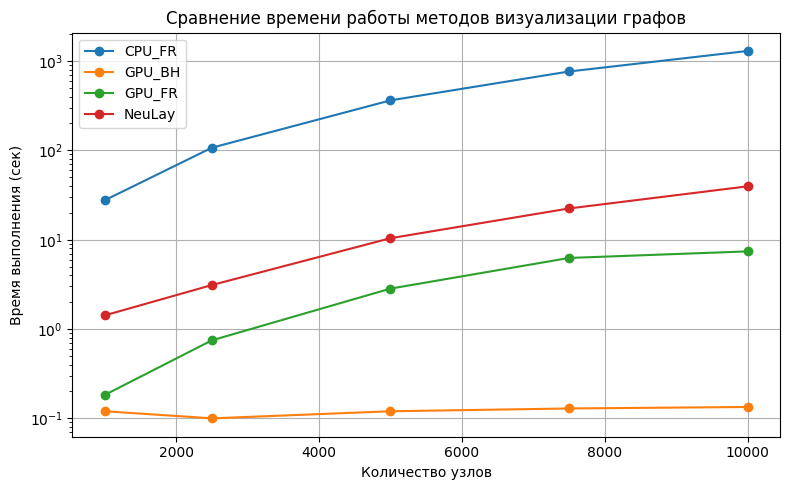

In [32]:
plt.figure(figsize=(8, 5))
for method, grp in df.groupby('method'):
    sizes = [int(g.split('_')[1]) for g in grp['graph']]
    plt.plot(sizes, grp['time_s'], marker='o', label=method)

plt.xlabel('Количество узлов')
plt.ylabel('Время выполнения (сек)')
plt.title('Сравнение времени работы методов визуализации графов')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [33]:
# Вычисляем базовое время для CPU_FR для каждого графа
data_cpu = df[df.method == 'CPU_FR'][['graph','time_s']].rename(columns={'time_s':'time_cpu'})
# Объединяем и считаем ускорение
df_speedup = df.merge(data_cpu, on='graph')
df_speedup['speedup'] = df_speedup['time_cpu'] / df_speedup['time_s']

df_speedup

,graph,method,time_s,time_cpu,speedup
0,ER_1000,CPU_FR,27.596668,27.596668,1.000000
1,ER_1000,GPU_FR,0.182653,27.596668,151.088143
2,ER_1000,GPU_BH,0.120302,27.596668,229.395133
3,ER_1000,NeuLay,1.420294,27.596668,19.430245
4,ER_2500,CPU_FR,106.994628,106.994628,1.000000
5,ER_2500,GPU_FR,0.747380,106.994628,143.159600
6,ER_2500,GPU_BH,0.100093,106.994628,1068.955701
7,ER_2500,NeuLay,3.107474,106.994628,34.431385
8,ER_5000,CPU_FR,362.834323,362.834323,1.000000
9,ER_5000,GPU_FR,2.835694,362.834323,127.952576


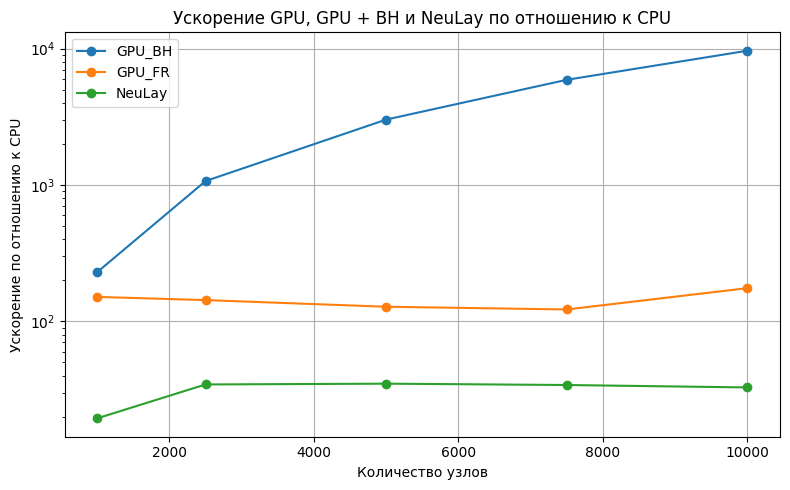

In [34]:
# Строим график ускорения
plt.figure(figsize=(8, 5))
for method, grp in df_speedup[df_speedup.method != 'CPU_FR'].groupby('method'):
    sizes = [int(name.split('_')[1]) for name in grp['graph']]
    plt.plot(sizes, grp['speedup'], marker='o', label=method)

plt.xlabel('Количество узлов')
plt.ylabel('Ускорение по отношению к CPU')
plt.title('Ускорение GPU, GPU + BH и NeuLay по отношению к CPU')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
def drawGraph(G, pos, name):
  plt.figure(figsize=(6, 6))
  nx.draw(G, pos, node_size=5, edge_color='grey', alpha=0.5)
  plt.title(f'{name}')
  plt.axis('off')
  plt.show()

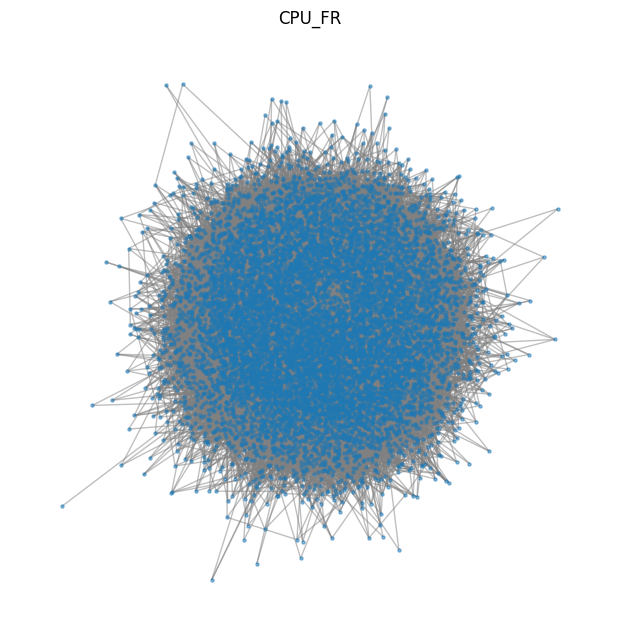

In [36]:
drawGraph(ER10000_G, pos_cpu, 'CPU_FR')

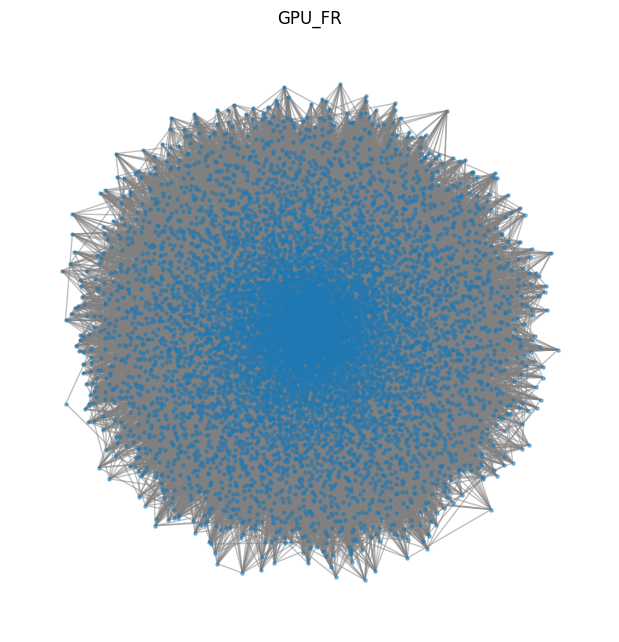

In [37]:
drawGraph(ER10000_G, pos_gpu, 'GPU_FR')

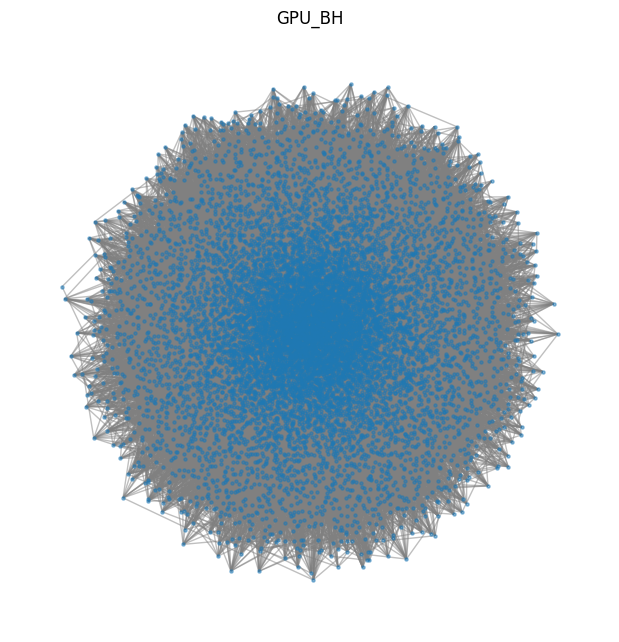

In [38]:
drawGraph(ER10000_G, pos_gpu_bh, 'GPU_BH')

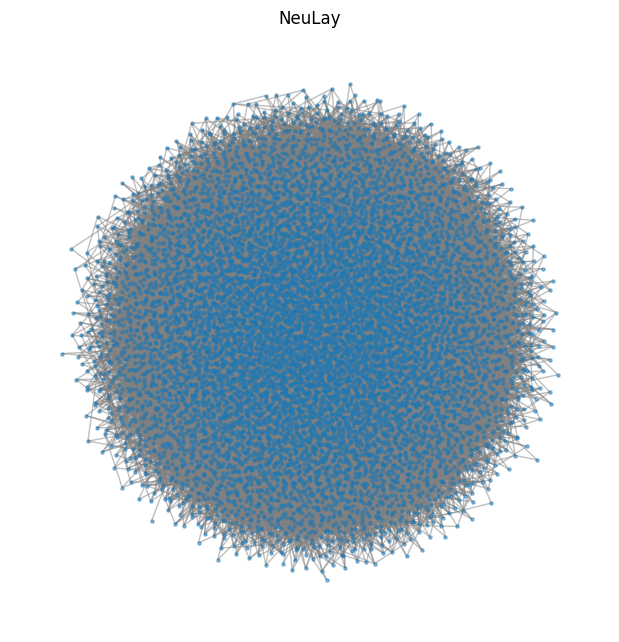

In [39]:
drawGraph(ER10000_G, pos_neulay, 'NeuLay')

In [ ]:
big_graphs = load_test_graphs([100000, 500000, 1000000])
big_results = []
for name, G in big_graphs.items():
    pos_gpu, t_gpu = benchmark_gpu_force(G, barnes_hut=False)
    pos_gpu_bh, t_gpu_bh = benchmark_gpu_force(G, barnes_hut=True)
    pos_neulay, t_neulay = benchmark_neulay(G)
    for method, t in [
        ("GPU_FR", t_gpu),
        ("GPU_BH", t_gpu_bh),
        ("NeuLay", t_neulay)
    ]:
        big_results.append({"graph": name, "method": method, "time_s": t})

# Create DataFrame
df_big = pd.DataFrame(results)

In [ ]:
plt.figure(figsize=(8, 5))
for method, grp in df_big.groupby('method'):
    sizes = [int(g.split('_')[1]) for g in grp['graph']]
    plt.plot(sizes, grp['time_s'], marker='o', label=method)

plt.xlabel('Количество узлов')
plt.ylabel('Время выполнения (сек)')
plt.title('Сравнение времени работы методов визуализации графов')
plt.yscale('log')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()